## Import 

In [1]:
import os
import torch
import sys
sys.path.append("../") # go to parent dir
import transformers
import torch
transformers.logging.set_verbosity_error()

In [2]:
TOKEN = os.environ['HUGGINGFACE_TOKEN']  # HuggingFace token
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
#MODEL_NAME_PATH = 'llama3-1-8B-Inst'
MODEL_NAME_PATH = 'llama3-2'
#VOCABULARY_SIZE = 128256
data_dir_path = f"../data/{MODEL_NAME_PATH}"
range_down= 1
range_up = 100
FILE_NAME = f"additions_from_{range_down}_to_{range_up}dataset.json"
OUTPUT_DIR=f"{MODEL_NAME_PATH}_results_interpreting_hidden_states_notebook"
FILE_LOGIT = f"logits_addition_{range_down}_{range_up}.json"

## Setup

In [4]:
import os
DEVELOPMENT_MODE = False
# Detect if we're running in Google Colab
try:
    import google.colab
    IN_COLAB = True
    print("Running as a Colab notebook")
except:
    IN_COLAB = False

# Hot reload in development mode & not running on the CD
if not IN_COLAB:
    from IPython import get_ipython
    ip = get_ipython()
    if not ip.extension_manager.loaded:
        ip.extension_manager.load('autoreload')
        %autoreload 

# Plotly needs a different renderer for VSCode/Notebooks vs Colab argh
import plotly.io as pio
pio.renderers.default = "notebook_connected"
print(f"Using renderer: {pio.renderers.default}")

Using renderer: notebook_connected


In [5]:
import circuitsvis as cv
# Testing that the library works
cv.examples.hello("Neel")

In [6]:
# Import stuff
import torch
import torch.nn as nn
import einops
from fancy_einsum import einsum
import tqdm.auto as tqdm
import plotly.express as px

from jaxtyping import Float
from functools import partial
# import transformer_lens
import transformer_lens.utils as utils
from transformer_lens.hook_points import (
    HookPoint,
)  # Hooking utilities
from transformer_lens import HookedTransformer, FactoredMatrix

# We turn automatic differentiation off, to save GPU memory, as this notebook focuses on model inference not model training.
torch.set_grad_enabled(False)

def imshow(tensor, renderer=None, xaxis="", yaxis="", **kwargs):
    px.imshow(utils.to_numpy(tensor), color_continuous_midpoint=0.0, color_continuous_scale="RdBu", labels={"x":xaxis, "y":yaxis}, **kwargs).show(renderer)

def imshow_subplot(tensor, renderer=None, xaxis="", yaxis="", **kwargs):
    px.imshow(utils.to_numpy(tensor), color_continuous_midpoint=0.0, color_continuous_scale="RdBu", labels={"x":xaxis, "y":yaxis}, **kwargs)

def line(tensor, renderer=None, xaxis="", yaxis="", **kwargs):
    px.line(utils.to_numpy(tensor), labels={"x":xaxis, "y":yaxis}, **kwargs).show(renderer)

def scatter(x, y, xaxis="", yaxis="", caxis="", renderer=None, **kwargs):
    x = utils.to_numpy(x)
    y = utils.to_numpy(y)
    px.scatter(y=y, x=x, labels={"x":xaxis, "y":yaxis, "color":caxis}, **kwargs).show(renderer)

In [7]:
device = utils.get_device()

In [8]:
# NBVAL_IGNORE_OUTPUT
# "meta-llama/Llama-3.2-3B"
# "EleutherAI/gpt-j-6B"
# "gpt2-small"
MODEL = "meta-llama/Llama-3.2-1B-Instruct"
#MODEL = "meta-llama/Llama-3.1-8B-Instruct"
#model = HookedTransformer.from_pretrained("meta-llama/Llama-3.2-1B-Instruct", device=device, torch_dtype= torch.bfloat16)
model = HookedTransformer.from_pretrained(MODEL, device=device, torch_dtype= torch.bfloat16)

Loaded pretrained model meta-llama/Llama-3.2-1B-Instruct into HookedTransformer


In [9]:
model

HookedTransformer(
  (embed): Embed()
  (hook_embed): HookPoint()
  (blocks): ModuleList(
    (0-15): 16 x TransformerBlock(
      (ln1): RMSNormPre(
        (hook_scale): HookPoint()
        (hook_normalized): HookPoint()
      )
      (ln2): RMSNormPre(
        (hook_scale): HookPoint()
        (hook_normalized): HookPoint()
      )
      (attn): GroupedQueryAttention(
        (hook_k): HookPoint()
        (hook_q): HookPoint()
        (hook_v): HookPoint()
        (hook_z): HookPoint()
        (hook_attn_scores): HookPoint()
        (hook_pattern): HookPoint()
        (hook_result): HookPoint()
        (hook_rot_k): HookPoint()
        (hook_rot_q): HookPoint()
      )
      (mlp): GatedMLP(
        (hook_pre): HookPoint()
        (hook_pre_linear): HookPoint()
        (hook_post): HookPoint()
      )
      (hook_attn_in): HookPoint()
      (hook_q_input): HookPoint()
      (hook_k_input): HookPoint()
      (hook_v_input): HookPoint()
      (hook_mlp_in): HookPoint()
      (hook_att

In [10]:
model.cfg

HookedTransformerConfig:
{'NTK_by_parts_factor': 32.0,
 'NTK_by_parts_high_freq_factor': 4.0,
 'NTK_by_parts_low_freq_factor': 1.0,
 'act_fn': 'silu',
 'attention_dir': 'causal',
 'attn_only': False,
 'attn_scale': np.float64(8.0),
 'attn_scores_soft_cap': -1.0,
 'attn_types': None,
 'checkpoint_index': None,
 'checkpoint_label_type': None,
 'checkpoint_value': None,
 'd_head': 64,
 'd_mlp': 8192,
 'd_model': 2048,
 'd_vocab': 128256,
 'd_vocab_out': 128256,
 'decoder_start_token_id': None,
 'default_prepend_bos': True,
 'device': device(type='cuda'),
 'dtype': torch.bfloat16,
 'eps': 1e-05,
 'experts_per_token': None,
 'final_rms': True,
 'from_checkpoint': False,
 'gated_mlp': True,
 'init_mode': 'gpt2',
 'init_weights': False,
 'initializer_range': np.float64(0.017677669529663688),
 'load_in_4bit': False,
 'model_name': 'Llama-3.2-1B-Instruct',
 'n_ctx': 2048,
 'n_devices': 1,
 'n_heads': 32,
 'n_key_value_heads': 8,
 'n_layers': 16,
 'n_params': 1073741824,
 'normalization_type': '

In [11]:
VOCABULARY_SIZE = model.cfg.d_vocab_out

## Generate logit addition data

We saw that the tags "correct" "incorrect" were not reliable, since they do not sometime correspond to "the correct digit is in the most probable", that is what we are considering.
So we need to save te logits for each one of them and build another dataset corrected.

In [11]:
import simplejson

with open(os.path.join(data_dir_path, FILE_NAME), "r") as f:
    data = simplejson.loads(f.read())

In [12]:
all_data = data['incorrect'] + data['correct'] # for memory reason do one at a time

In [ ]:
import torch 
from tqdm import tqdm

samples = [sample for sample in all_data]

batch=1
n_samples = len(samples)
d_vocab = model.cfg.d_vocab
topk = 50

#incorrect_logits = torch.empty(size=(n_samples, d_vocab)).to(DEVICE)
samples_with_logit = []
# Gather logits
for index, sample in tqdm(list(enumerate(samples))):
    prompt = f"{sample['op1']} + {sample['op2']} = "
    true_tokens = model.to_single_token(str(sample["true"]))
    tokens = model.to_tokens(prompt)
    # We run on the clean prompt with the cache so we store activations to patch in later.
    logits, cache = model.run_with_cache(tokens)
    #logit = logits[0, -1, :].float().detach().cpu().numpy()
    logit_rank = logits[0, -1, :].topk(topk)
    values = logit_rank.values
    indices = logit_rank.indices
    samples_with_logit.append({"op1": sample['op1'],
                               "op2":sample["op2"],
                               "true": sample['true'],
                               "logit_topk_values": values,
                               "logit_topk_indices": indices})
    

  0%|          | 0/250000 [00:00<?, ?it/s]

 94%|█████████▍| 235439/250000 [1:52:30<10:00, 24.23it/s]  

In [ ]:
import simplejson

with open(os.path.join(data_dir_path, FILE_NAME), "r") as f:
    simplejson.dump(samples_with_logit, f)

[{'op1': 1,
  'op2': 21,
  'true': 22,
  'logit': array([ 0.359375, -2.140625,  5.03125 , ..., -2.703125, -2.703125,
         -2.703125], dtype=float32)},
 {'op1': 1,
  'op2': 49,
  'true': 50,
  'logit': array([ 2.203125, -0.5625  ,  4.625   , ..., -3.171875, -3.171875,
         -3.171875], dtype=float32)},
 {'op1': 1,
  'op2': 55,
  'true': 56,
  'logit': array([ 2.265625  , -0.26757812,  6.15625   , ..., -3.140625  ,
         -3.140625  , -3.140625  ], dtype=float32)},
 {'op1': 1,
  'op2': 61,
  'true': 62,
  'logit': array([ 3.03125, -0.5    ,  5.75   , ..., -3.21875, -3.21875, -3.21875],
        dtype=float32)},
 {'op1': 1,
  'op2': 110,
  'true': 111,
  'logit': array([ 0.73828125, -0.609375  ,  5.8125    , ..., -3.0625    ,
         -3.0625    , -3.0625    ], dtype=float32)},
 {'op1': 1,
  'op2': 156,
  'true': 157,
  'logit': array([ 3.4375   ,  1.0859375,  7.03125  , ..., -3.09375  , -3.09375  ,
         -3.09375  ], dtype=float32)},
 {'op1': 1,
  'op2': 163,
  'true': 164,
  

## Performance on additions

In [12]:
import simplejson

with open(os.path.join(data_dir_path, FILE_LOGIT), "r") as f:
    data = simplejson.loads(f.read())

In [13]:
len(data)

10000

In [14]:
import os
from typing import List, Dict

import matplotlib.pyplot as plt
import numpy as np


def parse_results(results: Dict):
    """
    Parsing results from :
        {'correct': [{'op1': 1,
                        'op2': 1,
                        'prediction': 2,
                        'true': 2,
                        'generation': ' 2\n'}, ...],
        'incorrect': [{'op1': 1,
                        'op2': 1,
                        'prediction': 1,
                        'true': 2,
                        'generation': ' 2\n'}, ...]}
    
    return
        np.array(range1, range2) with 1 if is it is correct, 0 otherwise
    """
    all_additions = [(sample['op1'], sample['op2'], 1) for sample in results['correct']] + [(sample['op1'], sample['op2'], 0) for sample in results['incorrect']]
    return sorted(all_additions, key=(lambda x: (x[0], x[1])), reverse=False)

def parse_logits(data:List):
    """
    Parse data from the format [(prompt, most_prob_token, logits)]
    to tensor of logits on GPU
    """
    logits = torch.empty((len(data), VOCABULARY_SIZE)).to(DEVICE)
    for index, sample in enumerate(data):
        logits[index] = torch.tensor(sample[2])
    return logits

def plot_results(results: dict,
                     adds_1: List,
                     adds_2:List,
                     range1: int,
                     range2: int,
                     dir_path: str,
                     file_name: str):
    """
    Plots accuracy of operations
    """

    results = np.array([sample[2] for sample in parse_results(results)]).reshape((range1, range2))

    fig, ax = plt.subplots(figsize=(30, 30))
    im = ax.imshow(results, aspect='auto')

    # Show all ticks and label them with the respective list entries
    ax.set_xticks(np.arange(range1), labels=np.unique(adds_1))
    ax.set_yticks(np.arange(range2), labels=np.unique(adds_2))

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
    print("plotting results...")
    # Loop over data dimensions and create text annotations.
    #for i in range(100):
    #   for j in range(100):
    #       text = ax.text(j, i, round(results[i, j], 2),
    #                      ha="center", va="center", color="w", fontsize='large')
    print("Finished plotting.")
    ax.set_title("Operations correct/incorrect")
    plt.show()
    if not os.path.exists(dir_path):
        os.mkdir(dir_path)
    fig.savefig(os.path.join(dir_path, file_name))
    
def plot_results_from_logits(results: list,
                     adds_1: List,
                     adds_2:List,
                     range1: int,
                     range2: int,
                     dir_path: str,
                     file_name: str):
    """
    Plots accuracy of operations
    """

    results = np.array(results).reshape((range1, range2))

    fig, ax = plt.subplots(figsize=(30, 30))
    im = ax.imshow(results, aspect='auto')

    # Show all ticks and label them with the respective list entries
    ax.set_xticks(np.arange(range1), labels=np.unique(adds_1))
    ax.set_yticks(np.arange(range2), labels=np.unique(adds_2))

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
    print("plotting results...")
    # Loop over data dimensions and create text annotations.
    #for i in range(100):
    #   for j in range(100):
    #       text = ax.text(j, i, round(results[i, j], 2),
    #                      ha="center", va="center", color="w", fontsize='large')
    print("Finished plotting.")
    ax.set_title("Operations correct/incorrect")
    plt.show()
    if not os.path.exists(dir_path):
        os.mkdir(dir_path)
    fig.savefig(os.path.join(dir_path, file_name))

In [15]:
logits = parse_logits(data)

In [16]:
logits.shape

torch.Size([10000, 128256])

In [17]:
from itertools import product

def get_accuracy_array(model:HookedTransformer, logits: torch.Tensor, range_down: int, range_up:int):
    """
    Translate the logits into correct/incorrect if the most probable token is the right one
    """
    most_prob_ids = logits.topk(1, dim=-1).indices
    most_prob_tokens = model.tokenizer.convert_ids_to_tokens(most_prob_ids)
    correct_results = [str(op1 + op2)[:3] for op1, op2 in product(range(range_down, range_up + 1), range(range_down, range_up + 1))]
    print(f"Len of true results: {len(correct_results)}")
    print(f"Len of logits results: {len(most_prob_tokens)}")
    return [1  if token==true else 0 for token, true in zip(most_prob_tokens, correct_results)]

In [18]:
acc_result = get_accuracy_array(model, logits, range_down, range_up)

Len of true results: 10000
Len of logits results: 10000


plotting results...
Finished plotting.


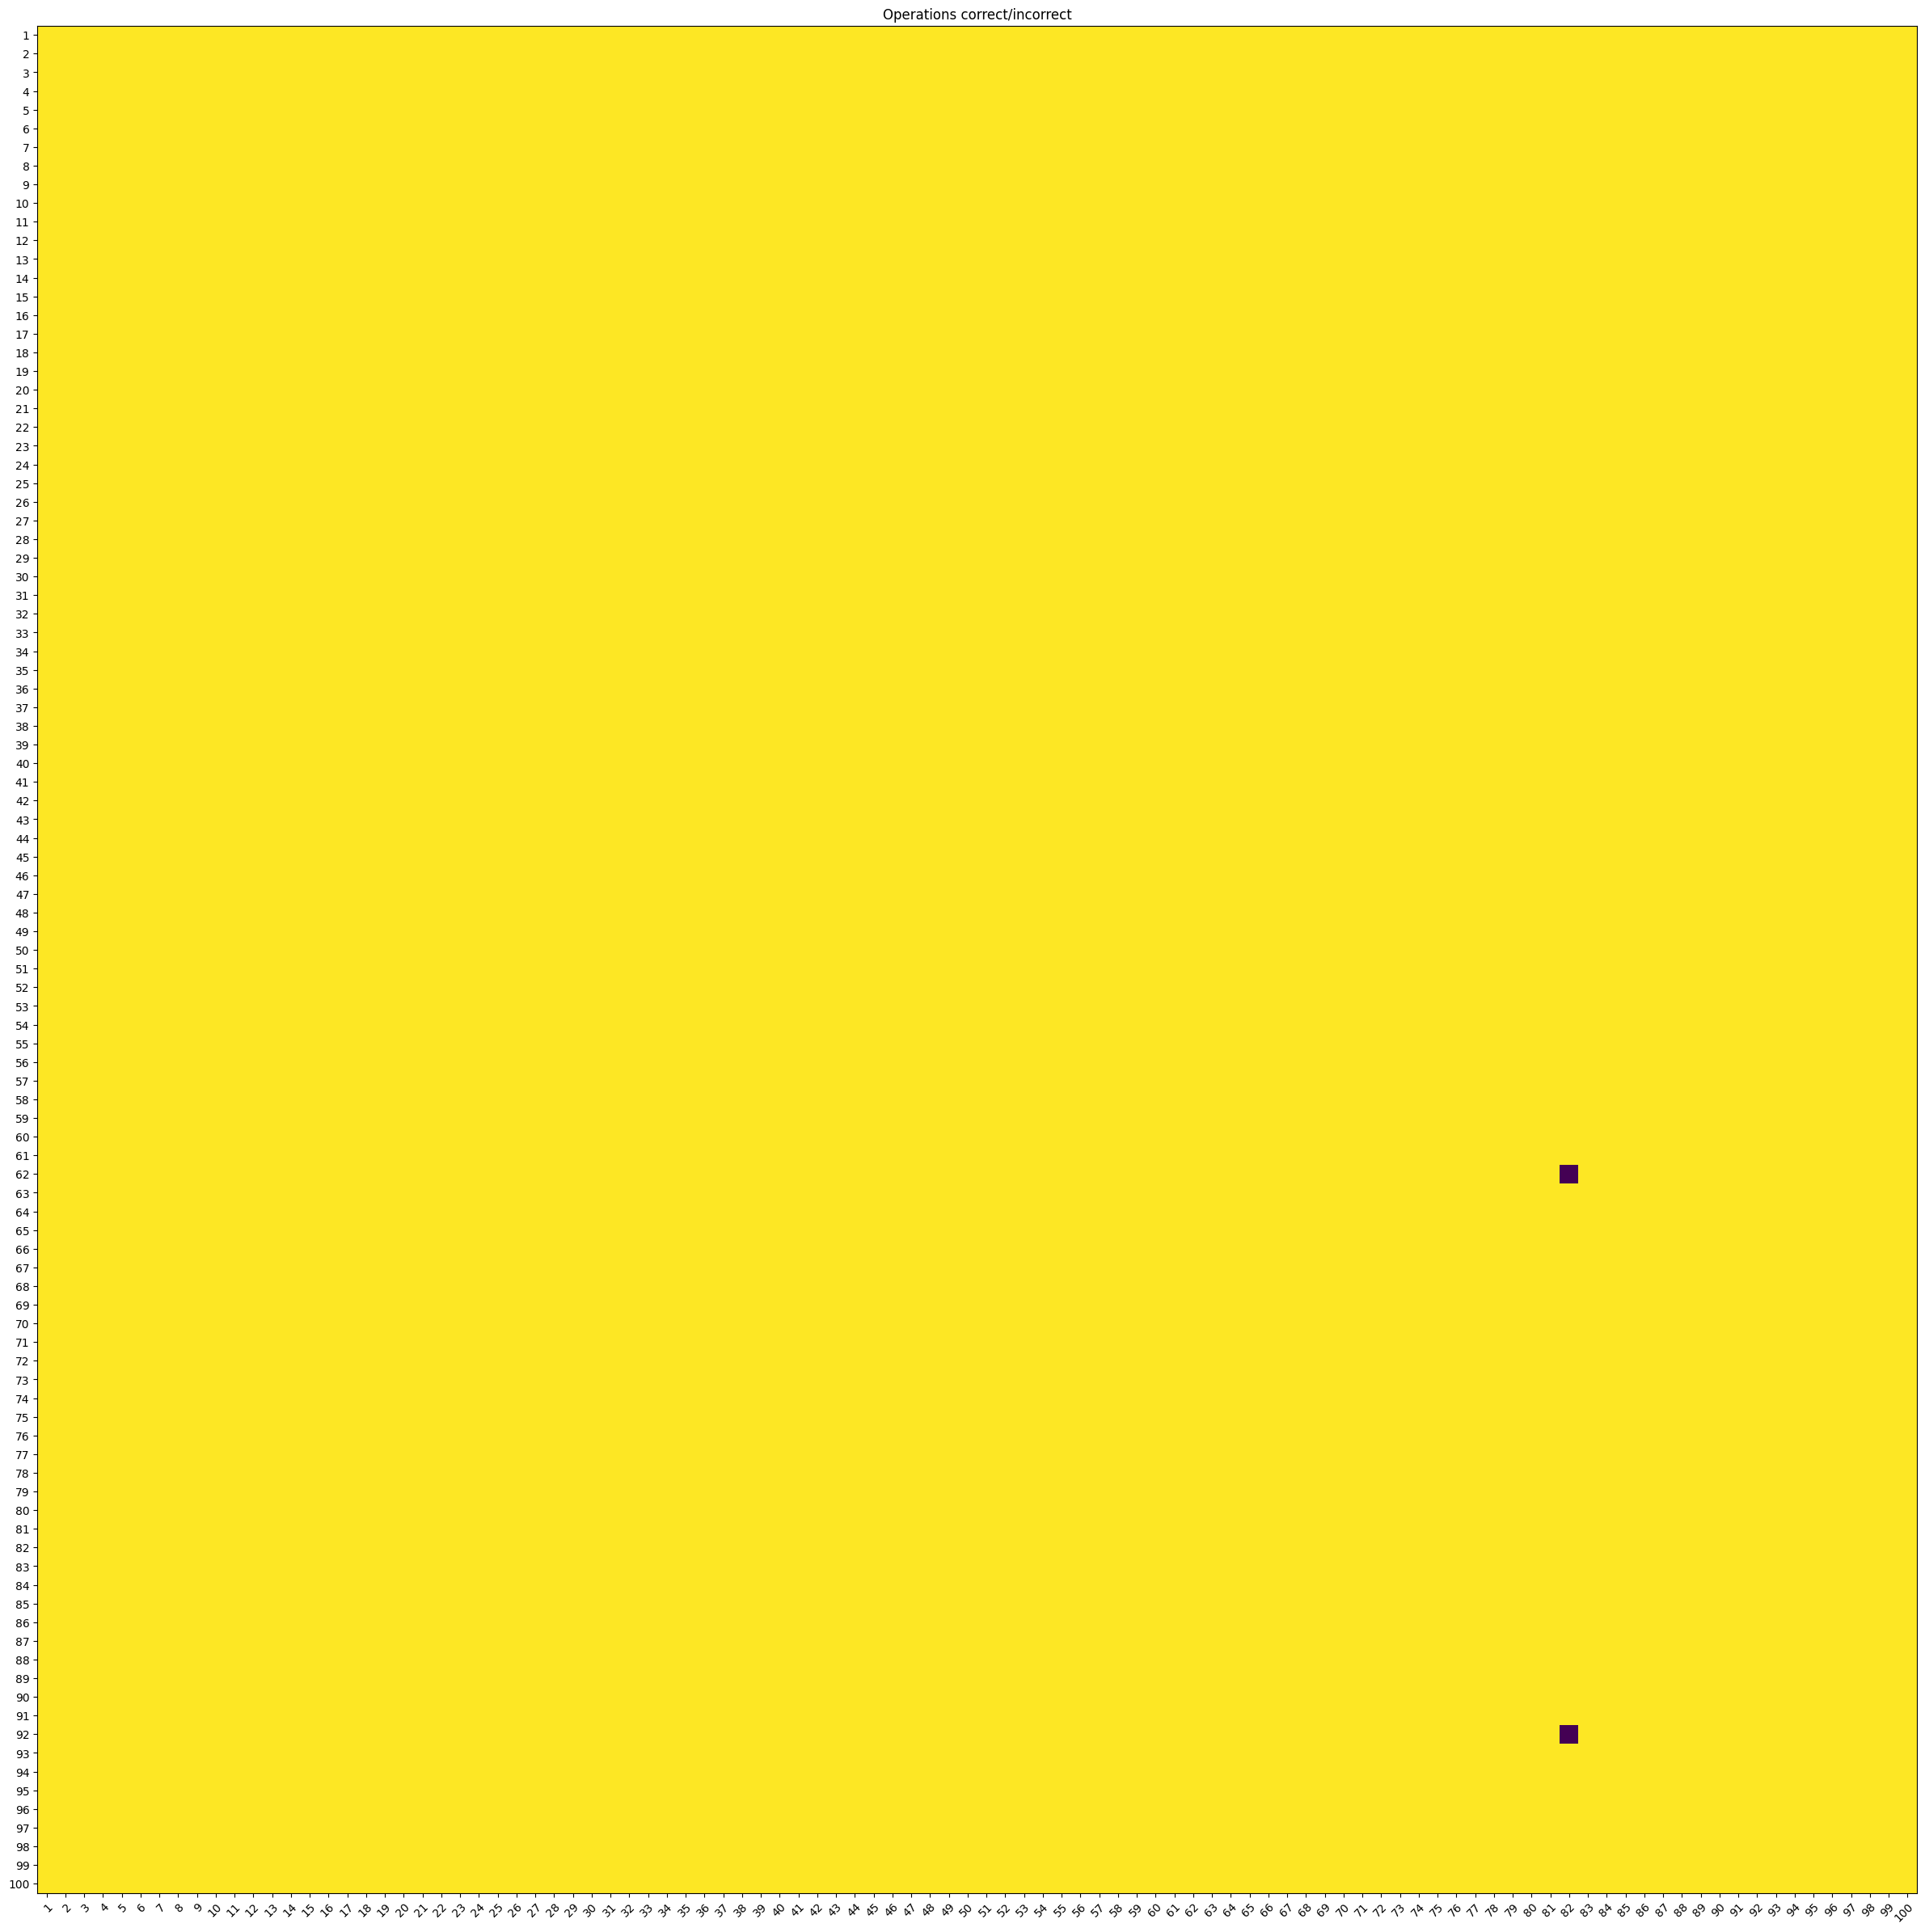

In [19]:
plot_results_from_logits(results=acc_result,
             adds_1=list(range(range_down, range_up + 1)),
             adds_2=list(range(range_down, range_up + 1)),
             range1=len(list(range(range_down, range_up + 1))),
             range2=len(list(range(range_down, range_up + 1))),
             dir_path=OUTPUT_DIR,
             file_name=f"accuracy_additions_{range_down}_{range_up}_{MODEL_NAME_PATH}")

## Experiment 1: check whether the model is using some aggregation of tokens or just looking at slices

### Plotting logit attribution of operands tokens according to direction 

In [12]:
# Choose an example with multiple tokens
op1 = 1029
op2 = 2861

prompt = f"{op1} + {op2} = "

In [13]:
from torch import Tensor
from jaxtyping import Float
from transformer_lens import ActivationCache

# Compute the direction 
def token_direction(model, op:str, slice:bool=False):
    """Compute the residual direction of a particular token

    Args:
        model (_type_): _description_
        op (str): _description_
        first_part (bool, optional): Whether slice the token and take the second part or not (assuming the operand is at most 2 tokens). Defaults to False.
    """
    if not slice:
        op_tokens = model.to_tokens(str(op)[:3], prepend_bos=False).T 
    else:
        op_tokens = model.to_tokens(str(op)[3:], prepend_bos=False).T
    op_residual_directions: Float[Tensor, "d_model"] = model.tokens_to_residual_directions(op_tokens)
    op_residual_directions = op_residual_directions.unsqueeze(0)
    return op_residual_directions

In [14]:
tokens = model.to_tokens(prompt)

# We run on the clean prompt with the cache so we store activations to patch in later.
logits, cache = model.run_with_cache(tokens)

In [15]:
model.to_str_tokens(tokens)

['<|begin_of_text|>', '102', '9', ' +', ' ', '286', '1', ' =', ' ']

In [16]:
op1_positions = [1, 2]
op2_positions = [5, 6]

In [17]:
from fancy_einsum import einsum

def residual_stack_projection_to_direction(
    residual_stack: Float[Tensor, "... batch d_model"],
    cache: ActivationCache,
    logit_diff_directions: Float[Tensor, "batch d_model"],
    position:int = -1
) -> Float[Tensor, "..."]:
    '''
    Gets the avg logit difference between the correct and incorrect answer for a given
    stack of components in the residual stream.
    '''
    # SOLUTION from https://colab.research.google.com/drive/1AA0wj2sHoZwtmy82WXORcZzk9urL1lVA#scrollTo=O80qgBSCl6mI
    batch_size = residual_stack.size(-2)
    scaled_residual_stack = cache.apply_ln_to_stack(residual_stack, layer=-1, pos_slice=position)
    return einops.einsum(
        scaled_residual_stack, logit_diff_directions.float(),
        "... batch d_model, batch d_model -> ..."
    ) / batch_size
    
import numpy as np

def to_numpy(tensor):
    """
    Helper function to convert a tensor to a numpy array. Also works on lists, tuples, and numpy arrays.
    """
    if isinstance(tensor, np.ndarray):
        return tensor
    elif isinstance(tensor, (list, tuple)):
        array = np.array(tensor)
        return array
    elif isinstance(tensor, (torch.Tensor, torch.nn.parameter.Parameter)):
        return tensor.detach().cpu().float().numpy()
    elif isinstance(tensor, (int, float, bool, str)):
        return np.array(tensor)
    else:
        raise ValueError(f"Input to to_numpy has invalid type: {type(tensor)}")

In [18]:
from plotly.express import line

# Computing how much each layer is writing in the direction of the first digits of the first operand in the first operand position 0
direction_op1 = token_direction(model, str(op1))

accumulated_residual, labels = cache.accumulated_resid(layer=-1, incl_mid=False, pos_slice=op1_positions[0], return_labels=True)
logit_lens_projection: Float[Tensor, "component"] = residual_stack_projection_to_direction(accumulated_residual, cache, direction_op1,
                                                                                           position=op1_positions[0])
to_plot = to_numpy(logit_lens_projection)
line(
    to_plot,
    #hovermode="x unified",
    title=f"How muh layers are writing in the direction {str(op1)[:3]} in position {model.to_str_tokens(tokens)[op1_positions[0]]}",
    labels={"x": "Layer", "y": "Logit Diff"},
    #xticks=labels,
    width=1100
).update_layout(
    xaxis = dict(
        tickmode = 'array',
        tickvals = list(range(len(labels))),
        ticktext = labels
    )
)


In [19]:
from plotly.express import line

# Computing how much each layer is writing in the direction of the first digits of the first operand in the first operand position 1
direction_op1 = token_direction(model, str(op1))

accumulated_residual, labels = cache.accumulated_resid(layer=-1, incl_mid=False, pos_slice=op1_positions[1], return_labels=True)
logit_lens_projection: Float[Tensor, "component"] = residual_stack_projection_to_direction(accumulated_residual, cache, direction_op1,
                                                                                           position=op1_positions[1])
to_plot = to_numpy(logit_lens_projection)
line(
    to_plot,
    #hovermode="x unified",
    title=f"How muh layers are writing in the direction {str(op1)[:3]} in position {model.to_str_tokens(tokens)[op1_positions[1]]}",
    labels={"x": "Layer", "y": "Logit Diff"},
    #xticks=labels,
    width=1100
).update_layout(
    xaxis = dict(
        tickmode = 'array',
        tickvals = list(range(len(labels))),
        ticktext = labels
    )
)


In [20]:
from plotly.express import line

# Computing how much each layer is writing in the direction of the last digit of the first operand in the first operand position 0
direction_op1 = token_direction(model, str(op1), slice=True)

accumulated_residual, labels = cache.accumulated_resid(layer=-1, incl_mid=False, pos_slice=op1_positions[0], return_labels=True)
logit_lens_projection: Float[Tensor, "component"] = residual_stack_projection_to_direction(accumulated_residual, cache, direction_op1,
                                                                                           position=op1_positions[0])
to_plot = to_numpy(logit_lens_projection)
line(
    to_plot,
    #hovermode="x unified",
    title=f"How muh layers are writing in the direction {str(op1)[3:]} in position {model.to_str_tokens(tokens)[op1_positions[0]]}",
    labels={"x": "Layer", "y": "Logit Diff"},
    #xticks=labels,
    width=1100
).update_layout(
    xaxis = dict(
        tickmode = 'array',
        tickvals = list(range(len(labels))),
        ticktext = labels
    )
)

In [21]:
from plotly.express import line

# Computing how much each layer is writing in the direction of the last digit of the first operand in the first operand position 1
direction_op1 = token_direction(model, str(op1), slice=True)

accumulated_residual, labels = cache.accumulated_resid(layer=-1, incl_mid=False, pos_slice=op1_positions[1], return_labels=True)
logit_lens_projection: Float[Tensor, "component"] = residual_stack_projection_to_direction(accumulated_residual, cache, direction_op1,
                                                                                           op1_positions[1])
to_plot = to_numpy(logit_lens_projection)
line(
    to_plot,
    #hovermode="x unified",
    title=f"How muh layers are writing in the direction {str(op1)[3:]} in position {model.to_str_tokens(tokens)[op1_positions[1]]}",
    labels={"x": "Layer", "y": "Logit Diff"},
    #xticks=labels,
    width=1100
).update_layout(
    xaxis = dict(
        tickmode = 'array',
        tickvals = list(range(len(labels))),
        ticktext = labels
    )
)

### What if instead we look at the same addition, but tokenized as single token?

In [22]:
# Choose an example with multiple tokens
op1 = 1029
op2 = 2861

prompt = f"{op1} + {op2} = "

In [23]:
print(model.to_str_tokens(prompt))
print(model.to_tokens(prompt))

['<|begin_of_text|>', '102', '9', ' +', ' ', '286', '1', ' =', ' ']
tensor([[128000,   4278,     24,    489,    220,  17361,     16,    284,    220]],
       device='cuda:0')


In [24]:
op1_digits_tokens = [model.to_single_token(digit) for digit in str(op1)]
print(model.tokenizer.convert_ids_to_tokens(op1_digits_tokens))
op2_digits_tokens = [model.to_single_token(digit) for digit in str(op2)]
print(model.tokenizer.convert_ids_to_tokens(op2_digits_tokens))

['1', '0', '2', '9']
['2', '8', '6', '1']


In [25]:
# substitute aggregated digits with single digits for each operand
manual_prompt = [128000] + op1_digits_tokens + [489, 220] + op2_digits_tokens + [284, 220]
manual_prompt = torch.tensor(manual_prompt).to(DEVICE)
tokens = model.tokenizer.convert_ids_to_tokens(manual_prompt)

In [26]:
tokens

['<|begin_of_text|>',
 '1',
 '0',
 '2',
 '9',
 'Ġ+',
 'Ġ',
 '2',
 '8',
 '6',
 '1',
 'Ġ=',
 'Ġ']

In [27]:
logits, cache = model.run_with_cache(manual_prompt)

In [28]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.express as px

# Plot single tokens
string_tokens = model.tokenizer.convert_ids_to_tokens(op1_digits_tokens)

fig = make_subplots(rows=len(op1_digits_tokens), cols=4, column_titles=[f"position '{digit}'" for digit in string_tokens] , 
                    row_titles=[f"direction '{digit}'" for digit in string_tokens])

for index, token in  enumerate(op1_digits_tokens):
    for position in range(1, 5):
        # Computing how much each layer is writing in the direction of the first digits of the first operand in the first operand position 0
        direction_op1 = token_direction(model, token)
        accumulated_residual, labels = cache.accumulated_resid(layer=-1, incl_mid=True, pos_slice=position, return_labels=True)
        logit_lens_projection: Float[Tensor, "component"] = residual_stack_projection_to_direction(accumulated_residual, cache, direction_op1,
                                                                                                position=position)
        to_plot = logit_lens_projection.detach().cpu().float().numpy().tolist()
        #fig.add_trace(line(
        #    to_plot,
        #    #hovermode="x unified",
        #    title=f"How muh layers are writing in the direction {model.tokenizer.convert_ids_to_tokens(token)} in position {tokens[position]}",
        #    labels={"x": "Layer", "y": "Logit Diff"},
        #    #xticks=labels,
        #    width=1100
        #).update_layout(
        #    xaxis = dict(
        #        tickmode = 'array',
        #        tickvals = list(range(len(labels))),
        #        ticktext = labels
        #    )
        #),
        #row=index, col=position)
        fig.add_trace(
            px.line(x=labels, y=to_plot)['data'][0],
        row=index+1, col=position)
        
fig.update_layout(height=1000, width=1000, title_text="How much each digit writes towards the other digits")
fig.show()


In [29]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.express as px

# plot cumulative tokens

string_tokens = model.tokenizer.convert_ids_to_tokens(op1_digits_tokens)

# convert the tokens to cumulative tokens and ids
cumulative_tokens = [op1_digits_tokens[max(0, i-3):i] for i in range(1, len(string_tokens)+1)]
cumulative_converted_tokens = [[model.tokenizer.convert_ids_to_tokens(t) for t in el] for el in cumulative_tokens ]
cumulative_converted_tokens = [[str(t) for t in el] for el in cumulative_converted_tokens ]
cumulative_converted_tokens = ["".join(el) for el in cumulative_converted_tokens]
cumulative_converted_ids = [model.tokenizer.convert_tokens_to_ids(t) for t in cumulative_converted_tokens ]

fig = make_subplots(rows=len(op1_digits_tokens), cols=4, column_titles=[f"position '{digit}'" for digit in string_tokens] , 
                    row_titles=[f"direction '{digit}'" for digit in cumulative_converted_tokens])

for index, token in  enumerate(cumulative_converted_ids):
    for position in range(1, 5):
        # Computing how much each layer is writing in the direction of the first digits of the first operand in the first operand position 0
        direction_op1 = token_direction(model, token)
        accumulated_residual, labels = cache.accumulated_resid(layer=-1, incl_mid=True, pos_slice=position, return_labels=True)
        logit_lens_projection: Float[Tensor, "component"] = residual_stack_projection_to_direction(accumulated_residual, cache, direction_op1,
                                                                                                position=position)
        to_plot = logit_lens_projection.detach().cpu().float().numpy().tolist()
        #fig.add_trace(line(
        #    to_plot,
        #    #hovermode="x unified",
        #    title=f"How muh layers are writing in the direction {model.tokenizer.convert_ids_to_tokens(token)} in position {tokens[position]}",
        #    labels={"x": "Layer", "y": "Logit Diff"},
        #    #xticks=labels,
        #    width=1100
        #).update_layout(
        #    xaxis = dict(
        #        tickmode = 'array',
        #        tickvals = list(range(len(labels))),
        #        ticktext = labels
        #    )
        #),
        #row=index, col=position)
        fig.add_trace(
            px.line(x=labels, y=to_plot)['data'][0],
        row=index+1, col=position)
        
fig.update_layout(height=1000, width=1000, title_text="How much each digit writes towards the cumulative number")
fig.show()

In [30]:
labels

['0_pre',
 '0_mid',
 '1_pre',
 '1_mid',
 '2_pre',
 '2_mid',
 '3_pre',
 '3_mid',
 '4_pre',
 '4_mid',
 '5_pre',
 '5_mid',
 '6_pre',
 '6_mid',
 '7_pre',
 '7_mid',
 '8_pre',
 '8_mid',
 '9_pre',
 '9_mid',
 '10_pre',
 '10_mid',
 '11_pre',
 '11_mid',
 '12_pre',
 '12_mid',
 '13_pre',
 '13_mid',
 '14_pre',
 '14_mid',
 '15_pre',
 '15_mid',
 'final_post']

### Anlaysis of incorrect logits

In [20]:
import torch 
from tqdm import tqdm

incorrect_prompts = [f"{sample['op1']} + {sample['op2']} = " for sample in data['incorrect']]
true_tokens = [model.to_single_token(str(sample["true"])) for sample in data['incorrect']]

batch=1
n_prompts = len(incorrect_prompts)
d_vocab = model.cfg.d_vocab

incorrect_logits = torch.empty(size=(n_prompts, d_vocab))

# Gather logits
for index, prompt in tqdm(list(enumerate(incorrect_prompts))):
    tokens = model.to_tokens(prompt)
    # We run on the clean prompt with the cache so we store activations to patch in later.
    logits, cache = model.run_with_cache(tokens)
    incorrect_logits[index, :] = logits[0, -1, :].float()

100%|██████████| 9119/9119 [02:54<00:00, 52.39it/s]


Let's see how the true tokens are positioned in the logits in terms of rank

In [41]:
from collections import defaultdict
topk = 10

predictions = [sample['prediction'] for sample in data['incorrect']]
trues = [sample["true"] for sample in data['incorrect']]

positions = defaultdict(list)

for index, prompt, answer, pred, true in zip(range(len(incorrect_prompts)), incorrect_prompts, true_tokens, predictions, trues):
    logit_rank = incorrect_logits[index].topk(topk)
    if answer in logit_rank.indices:
        if prompt=="1 + 156 = ":
            debug_prompt, debug_token, debug_pred, debug_true = prompt, answer, pred, true 
            debug_logit = incorrect_logits[index]
            break
        position = (logit_rank.indices == answer).nonzero(as_tuple=True)
        positions[int(position[0]) + 1].append({"prompt": prompt, 
                              "pred": pred, 
                              "true": true})
        #print(f"The correct token is in {int(position[0] )+ 1} position, the difference with the correct token is {pred - true}")
    else:
        #print(f"The token is not in the top {topk} tokens")
        positions[-1].append({"prompt": prompt, 
                              "pred": pred, 
                              "true": true})

In [46]:
debug_logit.topk(10)

torch.return_types.topk(
values=tensor([16.3750, 16.3750, 15.1250, 15.0625, 15.0625, 15.0000, 14.9375, 14.8125,
        14.3750, 14.2500]),
indices=tensor([10895,  9892, 11515,  1114,    16, 13460, 10674, 15574, 15666,    15]))

In [47]:
debug_token

10895

In [48]:
model.tokenizer.convert_ids_to_tokens(debug_token)

'157'

In [58]:
model.to_str_tokens(model.generate(model.to_tokens("1 + 156 = "), do_sample=False))

  0%|          | 0/10 [00:00<?, ?it/s]

['<|begin_of_text|>',
 '1',
 ' +',
 ' ',
 '156',
 ' =',
 ' ',
 '163',
 '\n',
 '2',
 ' +',
 ' ',
 '155',
 ' =',
 ' ',
 '157',
 '\n']

In [44]:
debug_true

157

In [45]:
debug_pred

163

In [52]:
[sample for sample in data["incorrect"] if sample['op1'] == 1 and sample['op2']==156]

[{'op1': 1,
  'op2': 156,
  'prediction': 163,
  'true': 157,
  'generation': ' 163\n'}]

In [ ]:
# Samples with position in the topk
for key, value in positions.items():
    if key >= 0:
        
print(f"Number of samples with true token in the top {topk}: {len(positions[])}")

defaultdict(list,
            {2: [{'prompt': '1 + 21 = ', 'pred': 32, 'true': 22},
              {'prompt': '1 + 49 = ', 'pred': 58, 'true': 50},
              {'prompt': '1 + 55 = ', 'pred': 66, 'true': 56},
              {'prompt': '1 + 61 = ', 'pred': 72, 'true': 62},
              {'prompt': '1 + 165 = ', 'pred': 170, 'true': 166},
              {'prompt': '1 + 213 = ', 'pred': 224, 'true': 214},
              {'prompt': '1 + 268 = ', 'pred': 279, 'true': 269},
              {'prompt': '1 + 310 = ', 'pred': 321, 'true': 311},
              {'prompt': '1 + 311 = ', 'pred': 322, 'true': 312},
              {'prompt': '1 + 313 = ', 'pred': 324, 'true': 314},
              {'prompt': '1 + 314 = ', 'pred': 325, 'true': 315},
              {'prompt': '1 + 315 = ', 'pred': 326, 'true': 316},
              {'prompt': '1 + 356 = ', 'pred': 361, 'true': 357},
              {'prompt': '1 + 361 = ', 'pred': 372, 'true': 362},
              {'prompt': '1 + 371 = ', 'pred': 382, 'true': 372},
 

## Experiment 2: activation patching to know which components are mostly related to the output

### Check attention patterns

In [12]:
# check average attention patterns of last position over additions from 0 to 100
# Choose an example with multiple tokens
op1 = 1029
op2 = 2861

prompt = f"{op1} + {op2} = "
tokens = model.to_tokens(prompt)

# We run on the clean prompt with the cache so we store activations to patch in later.
logits, cache = model.run_with_cache(tokens)

In [13]:
model.to_str_tokens(prompt)

['<|begin_of_text|>', '102', '9', ' +', ' ', '286', '1', ' =', ' ']

In [14]:
cache['pattern', 0].shape # shape [batch, head, dest_position, source_position]

torch.Size([1, 32, 9, 9])

In [15]:
attn_mat = cache['pattern', 5][:, :, 8]

In [16]:
attn_mat.shape

torch.Size([1, 32, 9])

In [24]:
from itertools import product

NUMBERS = list(range(1000, 1100))
N_NUMBERS = 100
operations = [(add1, add2) for add1, add2 in product(NUMBERS, NUMBERS)]

In [27]:
from torch import Tensor
from jaxtyping import Float

# Additions
def generate_embeddings(model: HookedTransformer, numbers_addition: list, positions:int)->Float[Tensor, "n_samples n_layers d_model"]:
    """Return attention patterns of last position of addition prompts. Assumes all prompt has the same numbers of tokens.

    Returns:
        _type_: _description_
    """
    patterns = torch.empty((len(numbers_addition), model.cfg.n_layers, model.cfg.n_heads, positions)).to(DEVICE)
    for index, (add1, add2) in enumerate(numbers_addition):
        prompt = f"{add1} + {add2} = "
        #prompt = f"2 + 2 = "
        #answer = str(chosen_sample['true'])[:3]  # Frist three chars of the result
        #answer = str(10)[:3]  # Frist three chars of the result
        tokens = model.to_tokens(prompt)
        # We run on the prompt with the cache so we store activations 
        logits, cache = model.run_with_cache(tokens)
        # Get the residuals from the cache of the last position,
        # cache.accumulated_resid returns all the residuals BEFORE each layer, until the parameter layer
        #residual = cache.accumulated_resid(layer=-1, incl_mid=False, return_labels=False)
        #print(residual.shape)
        for layer in range(model.cfg.n_layers):
            #residuals[index, layer] = residual[layer, :, position, :]
            patterns[index, layer] = cache[utils.get_act_name('pattern', 0)][:, :, -1]
            #residuals_1[index, :] = cache[utils.get_act_name('resid_pre', 1)][:, POSITION, :]
            #residuals_last[index, :] = cache[utils.get_act_name('resid_pre', 15)][:, POSITION, :]
    
    return patterns.mean(0)

In [28]:
patterns = generate_embeddings(model, operations, positions=9)

In [ ]:
patterns.shape

In [75]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.express as px
fig = make_subplots(rows=2, cols=8, subplot_titles=[f"Layer {layer}" for layer in range(model.cfg.n_layers)])

# Attention pattern for every layer in last position, divided by heads
layer_count = 0
for i in range(1, 3):
    for j in range(1, 9):
        attn_mat = cache['pattern', layer_count][:, :, 8]
        fig.add_trace(
                px.imshow(utils.to_numpy(attn_mat.mean(0)), color_continuous_midpoint=0.0, color_continuous_scale="RdBu", labels={"x":'Position', "y":'Head'})['data'][0].update({'colorscale':'RdBu'}),
                row=i,
                col=j,
                ).update_coloraxes({'colorscale':'RdBu', 'cmid': 0})
        fig.add_trace(
                go.Scatter(mode="markers", x=[1]*32, y=list(range(32)), marker_symbol=[101],
                   marker_color="red", 
                   marker_line_width=0.5, marker_size=8, hovertemplate= 'Position: %{x}<br>Head: %{y}',
                        showlegend=False),row=i,
                col=j)
        fig.add_trace(
                go.Scatter(mode="markers", x=[2]*32, y=list(range(32)), marker_symbol=[101],
                   marker_color="green", 
                   marker_line_width=0.5, marker_size=8, hovertemplate= 'Position: %{x}<br>Head: %{y}',
                        showlegend=False),row=i,
                col=j)
        fig.add_trace(
                go.Scatter(mode="markers", x=[5]*32, y=list(range(32)), marker_symbol=[101],
                   marker_color="red", 
                   marker_line_width=0.5, marker_size=8, hovertemplate= 'Position: %{x}<br>Head: %{y}',
                        showlegend=False),row=i,
                col=j)
        fig.add_trace(
                go.Scatter(mode="markers", x=[6]*32, y=list(range(32)), marker_symbol=[101],
                   marker_color="green", 
                   marker_line_width=0.5, marker_size=8, hovertemplate= 'Position: %{x}<br>Head: %{y}',
                        showlegend=False),row=i,
                col=j)

        layer_count += 1

fig.update_layout(height=1000, width=1000, title_text="Attention patterns of last token")
fig.show()

## Exp 

In [12]:
import torch

def indirect_effect(pre_patch_probs: torch.Tensor,
                    post_patch_probs: torch.Tensor,
                    clean_labels: torch.Tensor, 
                    corrupt_labels: torch.Tensor):
    """
    Measure indirect effect of a patch on probabilities, as described in Eq. 2 of "Understanding Arithmetic 
    Reasoning in Language Models using Causal Mediation Analysis".
    
    Args:
        pre_patch_probs (torch.Tensor (batch, vocab_size)): The probabilities before patching.
        post_patch_probs (torch.Tensor (batch, vocab_size)): The probabilities after patching.
        clean_labels (torch.Tensor(batch, 1)): The labels of the clean answers.
        corrupt_labels (torch.Tensor(batch, 1)): The label of the corrupt answers.

    Returns:
        torch.Tensor((batch,), dtype=torch.float32): The indirect effects for each prompt in the batch. The IE is not limited in magnitude.
    """
    a = (post_patch_probs.gather(1, corrupt_labels) - pre_patch_probs.gather(1, corrupt_labels)) / pre_patch_probs.gather(1, corrupt_labels)
    b = (pre_patch_probs.gather(1, clean_labels) - post_patch_probs.gather(1, clean_labels)) / post_patch_probs.gather(1, clean_labels)
    return (a + b).squeeze(1) / 2

def simple_logit_diff(logit_clean, logit_corrupted, token):
    # model.to_single_token maps a string value of a single token to the token index for that token
    # If the string is not a single token, it raises an error.
    index = model.to_single_token(token)
    return logit_clean[0, -1, :].softmax(dim=-1)[index] - logit_corrupted[0, -1, :].softmax(dim=-1)[index]

def drift_vector_similarity(model, cache_clean, cache_corrupted):
    '''Compute the cosine similarity between (last_hidden_state_clean - first_hidden_state_clean, last_hidden_state_corrupted - first_hidden_state_clean)'''
    last_hidden_state_clean = cache_clean[utils.get_act_name("resid_post", model.cfg.n_layers)][:, -1, :]
    first_hidden_state_clean = cache_clean[utils.get_act_name("resid_pre", 0)][:, -1, :]
    last_hidden_state_corrupted = cache_corrupted[utils.get_act_name("resid_post", model.cfg.n_layers)][:, -1, :]
    return torch.nn.CosineSimilarity(last_hidden_state_clean - first_hidden_state_clean, last_hidden_state_corrupted - first_hidden_state_clean)

def argmax_change(logit_clean, logit_corrupted):
    # returns 1 if the argmax of original logits has changed, otherwise returns 0
    if torch.argmax(logit_clean[0, -1]) != torch.argmax(logit_corrupted[0, -1]):
        return 1
    return 0

In [13]:
os.listdir()

['Test_Helix_LLama copy 2.ipynb',
 'path_patching_sota.ipynb',
 'data_generation_activation_patching.ipynb',
 'path_discovery_.ipynb',
 'llama3-2_results_interpreting_hidden_states_notebook',
 'path_discovery.ipynb',
 'path_discovery_links.ipynb',
 'interpreting_hidden_states.ipynb',
 'llama3-1-8B-Inst_results_interpreting_hidden_states_notebook',
 'test_transformer_lens.ipynb',
 'path_discovery_links_first_approach.ipynb',
 'parse_average_edges.ipynb',
 'exercises.ipynb']

In [14]:
import simplejson

with open(os.path.join(data_dir_path, FILE_NAME), "r") as f:
    data = simplejson.loads(f.read())

In [15]:
len(data['correct'])

9968

In [16]:
len(data['incorrect'])

32

In [17]:
print(data['correct'][4591])
print(data['incorrect'][22])
correct_sample = data['correct'][4591]
incorrect_sample = data['incorrect'][22]

{'op1': 47, 'op2': 6, 'prediction': 53, 'true': 53, 'generation': ' 53\n'}
{'op1': 69, 'op2': 71, 'prediction': 139, 'true': 140, 'generation': ' 139\n'}


In [18]:
incorrect_sample

{'op1': 69, 'op2': 71, 'prediction': 139, 'true': 140, 'generation': ' 139\n'}

In [19]:
#chosen_sample = incorrect_sample
chosen_sample = correct_sample

In [20]:
if chosen_sample == correct_sample:
    #answers_complete = (str(chosen_sample['true']), str(chosen_sample['true'] - 1 )) # random couterfactual prompt
    answers_complete = (str(chosen_sample['true']), "=") # random couterfactual prompt
else:
    answers_complete = (str(chosen_sample['true'])[:3], str(chosen_sample['prediction'])[:3])

In [21]:
answers_complete

('53', '=')

In [22]:
from copy import deepcopy
prompt = f"{chosen_sample['op1']} + {chosen_sample['op2']} = "
#prompt = f"2 + 2 = "
answer = str(chosen_sample['true'])[:3]  # Frist three chars of the result
#answer = str(10)[:3]  # Frist three chars of the result

tokens = model.to_tokens(prompt)

# We run on the clean prompt with the cache so we store activations to patch in later.
logits, cache = model.run_with_cache(tokens)

#cache = deepcopy(cache)

In [23]:
output = model.generate(model.to_tokens(prompt), do_sample=False)
model.to_string(output)

  0%|          | 0/10 [00:00<?, ?it/s]

['<|begin_of_text|>47 + 6 = 53\n53 + 3 = 56\n']

In [24]:
model.to_str_tokens(output)

['<|begin_of_text|>',
 '47',
 ' +',
 ' ',
 '6',
 ' =',
 ' ',
 '53',
 '\n',
 '53',
 ' +',
 ' ',
 '3',
 ' =',
 ' ',
 '56',
 '\n']

In [25]:
model.to_str_tokens("999 + 1000 + 109314 + 23 + 0")

['<|begin_of_text|>',
 '999',
 ' +',
 ' ',
 '100',
 '0',
 ' +',
 ' ',
 '109',
 '314',
 ' +',
 ' ',
 '23',
 ' +',
 ' ',
 '0']

## Logit attribution

In [26]:
from torch import Tensor
from jaxtyping import Float
from transformer_lens import ActivationCache

Compute the direction of "correct digit of the result"

In [27]:
answer_tokens = torch.concat([
    model.to_tokens(names, prepend_bos=False).T for names in answers_complete
])

In [28]:
answer_residual_directions: Float[Tensor, "batch 2 d_model"] = model.tokens_to_residual_directions(answer_tokens).to(DEVICE)
answer_residual_directions = einops.rearrange(answer_residual_directions, 
                                              "tokens batch d_model -> batch tokens d_model")

print("Answer residual directions shape:", answer_residual_directions.shape)

correct_residual_directions, incorrect_residual_directions = answer_residual_directions.unbind(dim=1)
logit_diff_directions: Float[Tensor, "batch d_model"] = correct_residual_directions - incorrect_residual_directions
print(f"Logit difference directions shape:", logit_diff_directions.shape)
print(f"Logit difference directions type:", logit_diff_directions.dtype)

Answer residual directions shape: torch.Size([1, 2, 2048])
Logit difference directions shape: torch.Size([1, 2048])
Logit difference directions type: torch.bfloat16


In [53]:
def residual_stack_to_logit_diff(
    residual_stack: Float[Tensor, "... batch d_model"],
    cache: ActivationCache,
    logit_diff_directions: Float[Tensor, "batch d_model"] = logit_diff_directions,
    position: int = -1
) -> Float[Tensor, "..."]:
    '''
    Gets the avg logit difference between the correct and incorrect answer for a given
    stack of components in the residual stream.
    '''
    # SOLUTION from https://colab.research.google.com/drive/1AA0wj2sHoZwtmy82WXORcZzk9urL1lVA#scrollTo=O80qgBSCl6mI
    batch_size = residual_stack.size(-2)
    scaled_residual_stack = cache.apply_ln_to_stack(residual_stack, layer=-1, pos_slice=position)
    print(scaled_residual_stack.dtype)
    return einops.einsum(
        scaled_residual_stack, logit_diff_directions.float(),
        "... batch d_model, batch d_model -> ..."
    ) / batch_size



In [34]:
import numpy as np

def to_numpy(tensor):
    """
    Helper function to convert a tensor to a numpy array. Also works on lists, tuples, and numpy arrays.
    """
    if isinstance(tensor, np.ndarray):
        return tensor
    elif isinstance(tensor, (list, tuple)):
        array = np.array(tensor)
        return array
    elif isinstance(tensor, (torch.Tensor, torch.nn.parameter.Parameter)):
        return tensor.detach().cpu().float().numpy()
    elif isinstance(tensor, (int, float, bool, str)):
        return np.array(tensor)
    else:
        raise ValueError(f"Input to to_numpy has invalid type: {type(tensor)}")

In [35]:
print(accumulated_residual.dtype)

torch.bfloat16


In [36]:
from plotly.express import line

accumulated_residual, labels = cache.accumulated_resid(layer=-1, incl_mid=True, pos_slice=-1, return_labels=True)
# accumulated_residual has shape (component, batch, d_model)

logit_lens_logit_diffs: Float[Tensor, "component"] = residual_stack_to_logit_diff(accumulated_residual, cache)

to_plot = to_numpy(logit_lens_logit_diffs)
line(
    to_plot,
    #hovermode="x unified",
    title="Logit Difference From Accumulated Residual Stream",
    labels={"x": "Layer", "y": "Logit Diff"},
    #xticks=labels,
    width=1100
).update_layout(
    xaxis = dict(
        tickmode = 'array',
        tickvals = list(range(len(labels))),
        ticktext = labels
    )
)

torch.float32


In [37]:
from plotly.express import line

per_layer_residual, labels = cache.decompose_resid(layer=-1, pos_slice=-1, return_labels=True)
per_layer_logit_diffs = residual_stack_to_logit_diff(per_layer_residual, cache)

to_plot = to_numpy(per_layer_logit_diffs)
line(
    to_plot,
    #hovermode="x unified",
    title="Logit Difference From Accumulated Residual Stream",
    labels={"x": "Layer", "y": "Logit Diff"},
    #xticks=labels,
    width=1100
).update_layout(
    xaxis = dict(
        tickmode = 'array',
        tickvals = list(range(len(labels))),
        ticktext = labels
    )
)

torch.float32


In [38]:
from plotly.express import imshow
per_head_residual, labels = cache.stack_head_results(layer=-1, pos_slice=-1, return_labels=True)
per_head_residual = einops.rearrange(
    per_head_residual,
    "(layer head) ... -> layer head ...",
    layer=model.cfg.n_layers
)
per_head_logit_diffs = residual_stack_to_logit_diff(per_head_residual, cache)
to_plot = to_numpy(per_head_logit_diffs)
imshow(
    to_plot,
    labels={"x":"Head", "y":"Layer"},
    title="Logit Difference From Each Head",
    width=600,
    color_continuous_scale="RdBu",
    color_continuous_midpoint=0.0
)

Tried to stack head results when they weren't cached. Computing head results now
torch.float32


In [100]:
from IPython.display import display, HTML

def topk_of_Nd_tensor(tensor: Float[Tensor, "rows cols"], k: int):
    '''
    Helper function: does same as tensor.topk(k).indices, but works over 2D tensors.
    Returns a list of indices, i.e. shape [k, tensor.ndim].

    Example: if tensor is 2D array of values for each head in each layer, this will
    return a list of heads.
    '''
    i = torch.topk(tensor.flatten(), k).indices
    return np.array(np.unravel_index(utils.to_numpy(i), tensor.shape)).T.tolist()


k = 5

for head_type in ["Positive", "Negative"]:

    # Get the heads with largest (or smallest) contribution to the logit difference
    top_heads = topk_of_Nd_tensor(per_head_logit_diffs * (1 if head_type=="Positive" else -1), k)

    # Get all their attention patterns
    attn_patterns_for_important_heads: Float[Tensor, "head q k"] = torch.stack([
        cache["pattern", layer][:, head][0]
         for layer, head in top_heads
    ])

    # Display results
    display(HTML(f"<h2>Top {k} {head_type} Logit Attribution Heads</h2>"))
    display(cv.attention.attention_heads(
        attention = attn_patterns_for_important_heads,
        tokens = model.to_str_tokens(tokens[0]),
        attention_head_names = [f"{layer}.{head}" for layer, head in top_heads],
    ))

#### What if we plot how much each attention is writing into the direction of one operand ?

Specifically, we want to understand at which layer the information of the operands are passed to the last stack (i.e. position) and process to do the addition

In [54]:
model.to_str_tokens(prompt)

['<|begin_of_text|>', '47', ' +', ' ', '6', ' =', ' ']

In [55]:
op1 = chosen_sample['op1']
op2 = chosen_sample['op2']

print(f"Operand 1 is: {op1}")
print(f"Operand 2 is: {op2}")
print(f"Result is {chosen_sample['true']}")

Operand 1 is: 47
Operand 2 is: 6
Result is 53


In [56]:
op1_tokens = model.to_tokens(str(op1), prepend_bos=False).T 
op1_residual_directions: Float[Tensor, "d_model"] = model.tokens_to_residual_directions(op1_tokens)
op1_residual_directions = op1_residual_directions.unsqueeze(0)

op2_tokens = model.to_tokens(str(op2), prepend_bos=False).T 
op2_residual_directions: Float[Tensor, "d_model"] = model.tokens_to_residual_directions(op2_tokens)
op2_residual_directions = op2_residual_directions.unsqueeze(0)

In [57]:
op1_residual_directions.shape

torch.Size([1, 2048])

In [58]:
from plotly.express import line

accumulated_residual, labels = cache.accumulated_resid(layer=-1, incl_mid=True, pos_slice=1, return_labels=True)
# accumulated_residual has shape (component, batch, d_model)

logit_lens_logit_diffs: Float[Tensor, "component"] = residual_stack_to_logit_diff(accumulated_residual, cache, logit_diff_directions=op1_residual_directions,
                                                                                  position=1)

to_plot = to_numpy(logit_lens_logit_diffs)
line(
    to_plot,
    #hovermode="x unified",
    title="Logit Difference From Accumulated Residual Stream",
    labels={"x": "Layer", "y": "Logit Diff"},
    #xticks=labels,
    width=1100
).update_layout(
    xaxis = dict(
        tickmode = 'array',
        tickvals = list(range(len(labels))),
        ticktext = labels
    )
)

torch.float32


In [59]:
from plotly.express import line

per_layer_residual, labels = cache.decompose_resid(layer=-1, pos_slice=-1, return_labels=True)
per_layer_logit_diffs = residual_stack_to_logit_diff(per_layer_residual, cache, 
                                                     logit_diff_directions=op1_residual_directions)

to_plot = to_numpy(per_layer_logit_diffs)
line(
    to_plot,
    #hovermode="x unified",
    title="Logit Difference From Accumulated Residual Stream",
    labels={"x": "Layer", "y": "Logit Diff"},
    #xticks=labels,
    width=1100
).update_layout(
    xaxis = dict(
        tickmode = 'array',
        tickvals = list(range(len(labels))),
        ticktext = labels
    )
)

torch.float32


In [64]:
from plotly.express import line

accumulated_residual, labels = cache.accumulated_resid(layer=-1, incl_mid=True, pos_slice=4, return_labels=True)
# accumulated_residual has shape (component, batch, d_model)

logit_lens_logit_diffs: Float[Tensor, "component"] = residual_stack_to_logit_diff(accumulated_residual, cache, logit_diff_directions=op2_residual_directions,
                                                                                  position=4)

to_plot = to_numpy(logit_lens_logit_diffs)
line(
    to_plot,
    #hovermode="x unified",
    title="Logit Difference From Accumulated Residual Stream",
    labels={"x": "Layer", "y": "Logit Diff"},
    #xticks=labels,
    width=1100
).update_layout(
    xaxis = dict(
        tickmode = 'array',
        tickvals = list(range(len(labels))),
        ticktext = labels
    )
)

torch.float32


## Helix structure

In this section we explore periodicity in the embedings following the work https://arxiv.org/pdf/2502.00873

In [116]:
NUMBERS = list(range(0, 1000))

In [117]:
residuals_0 = torch.empty((len(NUMBERS), model.cfg.d_model))
residuals_1 = torch.empty((len(NUMBERS), model.cfg.d_model))
for index, number in enumerate(NUMBERS):
    prompt = str(number)
    #prompt = f"2 + 2 = "
    #answer = str(chosen_sample['true'])[:3]  # Frist three chars of the result
    #answer = str(10)[:3]  # Frist three chars of the result
    tokens = model.to_tokens(prompt, prepend_bos=False)
    # We run on the prompt with the cache so we store activations 
    logits, cache = model.run_with_cache(tokens)
    # Get the residuals from the cache of the last position,
    # cache.accumulated_resid returns all the residuals BEFORE each layer, until the paramenter layer
    residual = cache.accumulated_resid(layer=1, incl_mid=False, pos_slice=-1, return_labels=False)
    residuals_0[index, :] = residual[0, ...]
    residuals_1[index, :] = residual[1, ...]

In [118]:
residuals_0.shape

torch.Size([1000, 2048])

In [119]:
residuals_0.dtype

torch.float32

In [120]:
residuals_0.cpu().detach().shape

torch.Size([1000, 2048])

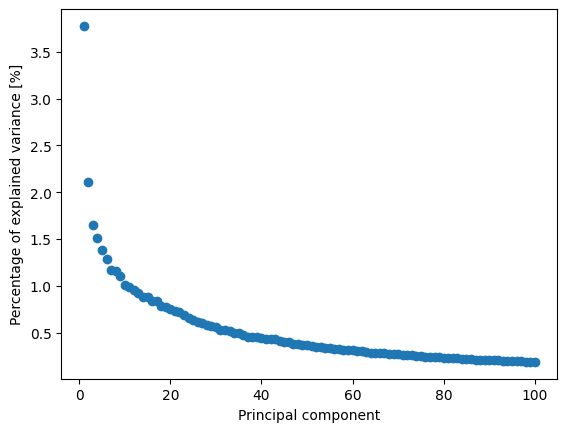

In [121]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Assume final_embeddings is a PyTorch tensor of shape [n_samples, 4096]
# Convert to NumPy for PCA processing
embeddings_np = residuals_0.float().numpy()

# Apply PCA (keep the first 100 components)
N_COMP = 100
pca = PCA(n_components=N_COMP).fit(embeddings_np)
# Compute the PCA vectors & variance

# Reconstruct the data using the PCA model
#Y = WPCA(n_components=N_COMP).fit_reconstruct(X)
    
pca_result = pca.fit_transform(embeddings_np)  # Shape: [n_samples, 100]

# Get explained variance for each component
explained_variance = pca.explained_variance_ratio_
explained_variancecs = explained_variance.cumsum()
plt.scatter(range(1,N_COMP + 1), explained_variance*100)
plt.xlabel("Principal component")
plt.ylabel("Percentage of explained variance [%]")
plt.show()

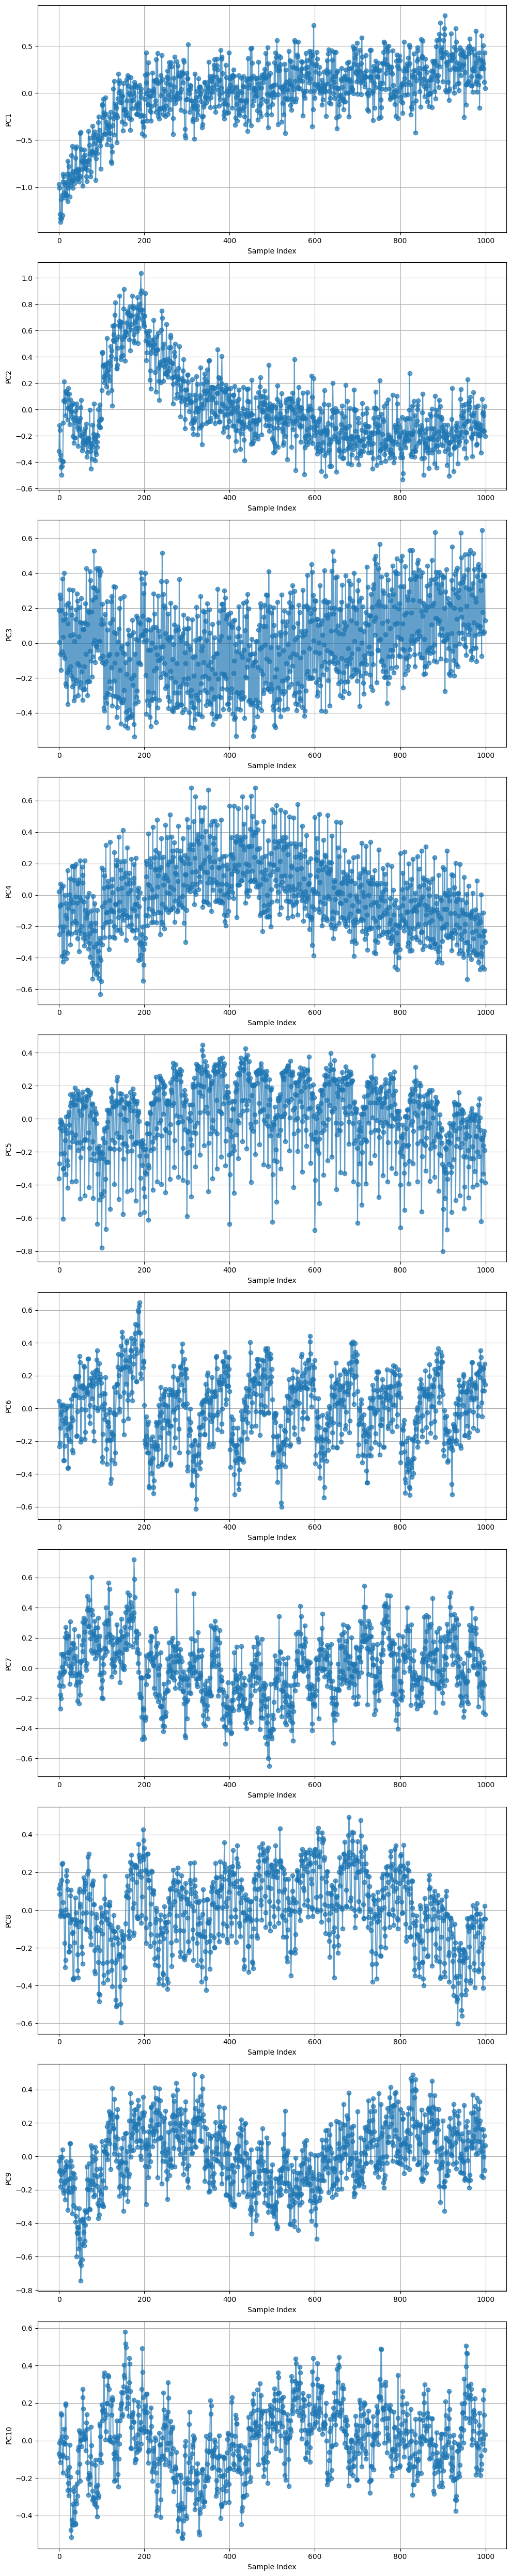

In [122]:
from sklearn.decomposition import KernelPCA

# Assume final_embeddings is a PyTorch tensor of shape [n_samples, model.cfg.d_model]
# Convert to NumPy for PCA processing
embeddings_np = residuals_1.float().numpy()

# Apply PCA (keep the first 100 components)
pca = PCA(n_components=10)
pca_result = pca.fit_transform(embeddings_np)  # Shape: [n_samples, 100]
#kpca = KernelPCA(n_components = 20,kernel='cosine') #'rbf', gamma=15)
#pca_result = kpca.fit_transform(embeddings_np)
 
# Get explained variance for each component
explained_variance = pca.explained_variance_ratio_

# Create subplots
num_components = pca_result.shape[1]
fig, axes = plt.subplots(num_components, 1, figsize=(10, 5 * num_components))

# Plot each principal component in a separate subplot
for i in range(num_components):
    axes[i].plot(NUMBERS, pca_result[:, i], marker='o', linestyle='-', alpha=0.7)
    axes[i].set_xlabel("Sample Index")
    axes[i].set_ylabel(f"PC{i+1}")
#    axes[i].set_title(f"Principal Component {i+1} (Explained Variance: {explained_variance[i]:.2%})")
    axes[i].grid()

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

In [19]:
pca_result.shape

(100, 10)

In [124]:
# fit cosine to data
from scipy import optimize
import numpy as np

def sin_func(x, a, b, c):
    return a * np.sin((x*(2*np.pi)/b) + c)

PCA_COMPONENT = 0
x_data = np.array(range(0, 1000))
y_data = pca_result[:, PCA_COMPONENT]
params, params_covariance = optimize.curve_fit(sin_func, x_data, y_data,
                                               p0=[0.5, 200, -7])

print(params)


[-1.18058514e-01  1.99881151e+02 -6.08472938e+00]


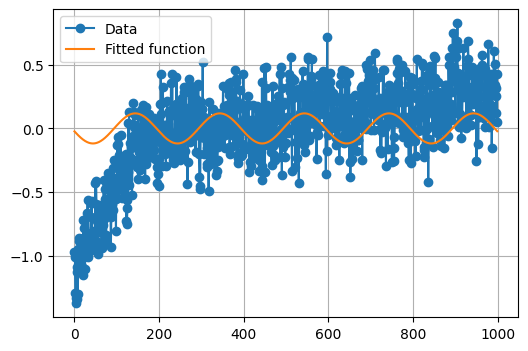

In [125]:
plt.figure(figsize=(6, 4))
plt.plot(x_data, y_data, label='Data', marker="o")
plt.plot(x_data, sin_func(x_data, params[0], params[1], params[2]),
         label='Fitted function')

plt.legend(loc='best')
plt.grid()

plt.show()

[-2.68477305e-01  1.01904844e+03  5.22302493e-01]


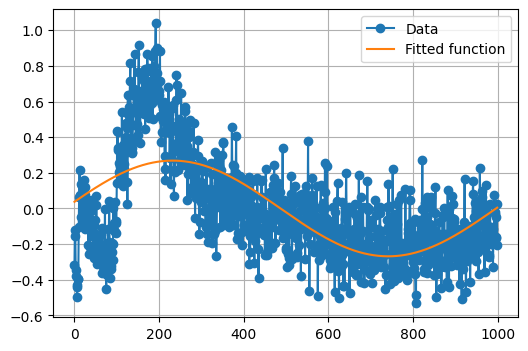

In [129]:
# fit cosine to data
from scipy import optimize
import numpy as np

def sin_func(x, a, b, c):
    return a * np.sin(2*np.pi*(x/b + c))

PCA_COMPONENT = 1
x_data = np.array(range(0, 1000))
y_data = pca_result[:, PCA_COMPONENT]
p0=[1, 10000, 1]
params, params_covariance = optimize.curve_fit(sin_func, x_data, y_data,
                                               p0=p0)

print(params)
plt.figure(figsize=(6, 4))
plt.plot(x_data, y_data, label='Data', marker="o")
plt.plot(x_data, sin_func(x_data, params[0], params[1], params[2]),
         label='Fitted function')
#plt.plot(x_data, sin_func(x_data, *p0),
#         label='String function')

plt.legend(loc='best')
plt.grid()
plt.show()


[ 0.29198994 75.36168782 -0.35325545]


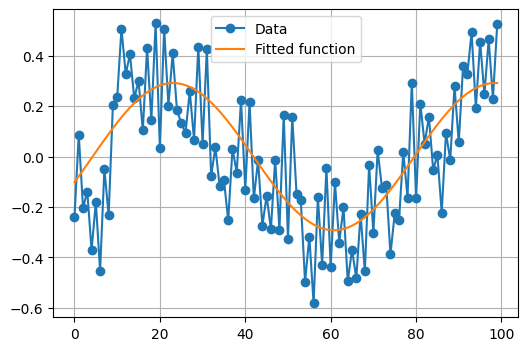

In [23]:
# fit cosine to data
from scipy import optimize
import numpy as np

def sin_func(x, a, b, c):
    return a * np.sin((x*(2*np.pi)/b) + c)

PCA_COMPONENT = 2
x_data = np.array(range(0, 100))
y_data = pca_result[:, PCA_COMPONENT]
p0=[1, 100, 1]
params, params_covariance = optimize.curve_fit(sin_func, x_data, y_data,
                                               p0=p0)

print(params)
plt.figure(figsize=(6, 4))
plt.plot(x_data, y_data, label='Data', marker="o")
plt.plot(x_data, sin_func(x_data, params[0], params[1], params[2]),
         label='Fitted function')
#plt.plot(x_data, sin_func(x_data, *p0),
#         label='String function')

plt.legend(loc='best')
plt.grid()
plt.show()


[ 0.17282617 66.42879137 -1.53576526]


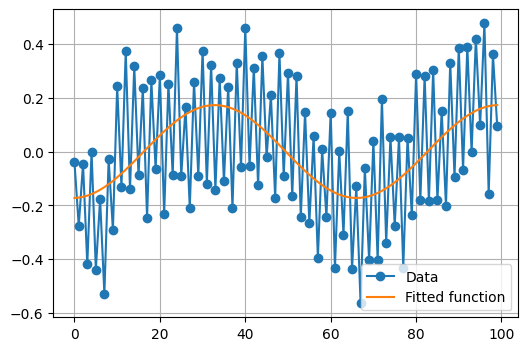

In [24]:
# fit cosine to data
from scipy import optimize
import numpy as np

def sin_func(x, a, b, c):
    return a * np.sin((x*(2*np.pi)/b) + c)

PCA_COMPONENT = 3
x_data = np.array(range(0, 100))
y_data = pca_result[:, PCA_COMPONENT]
p0=[1, 100, 1]
params, params_covariance = optimize.curve_fit(sin_func, x_data, y_data,
                                               p0=p0)

print(params)
plt.figure(figsize=(6, 4))
plt.plot(x_data, y_data, label='Data', marker="o")
plt.plot(x_data, sin_func(x_data, params[0], params[1], params[2]),
         label='Fitted function')
#plt.plot(x_data, sin_func(x_data, *p0),
#         label='String function')

plt.legend(loc='best')
plt.grid()
plt.show()

[-0.25607915 10.02383494  0.81892978]


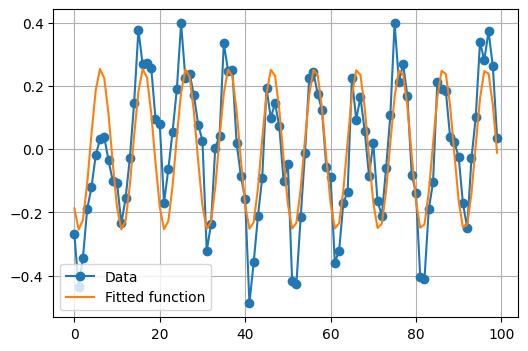

In [25]:
# fit cosine to data
from scipy import optimize
import numpy as np

def sin_func(x, a, b, c):
    return a * np.sin((x*(2*np.pi)/b) + c)

PCA_COMPONENT = 7
x_data = np.array(range(0, 100))
y_data = pca_result[:, PCA_COMPONENT]
p0=[1, 10, 1]
params, params_covariance = optimize.curve_fit(sin_func, x_data, y_data,
                                               p0=p0)

print(params)
plt.figure(figsize=(6, 4))
plt.plot(x_data, y_data, label='Data', marker="o")
plt.plot(x_data, sin_func(x_data, params[0], params[1], params[2]),
         label='Fitted function')
#plt.plot(x_data, sin_func(x_data, *p0),
#         label='String function')

plt.legend(loc='best')
plt.grid()
plt.show()

[3.62317902e-02 1.03098797e+02 2.14363861e+00]


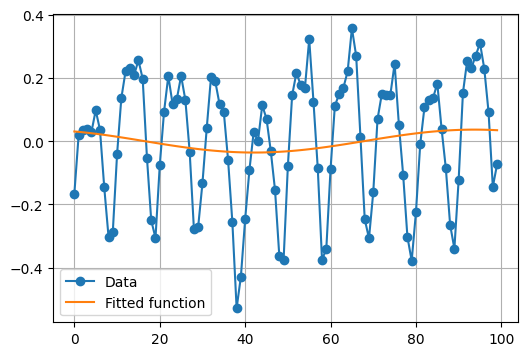

In [26]:
# fit cosine to data
from scipy import optimize
import numpy as np

def sin_func(x, a, b, c):
    return a * np.sin((x*(2*np.pi)/b) + c)

PCA_COMPONENT = 8
x_data = np.array(range(0, 100))
y_data = pca_result[:, PCA_COMPONENT]
p0=[1, 100, 1]
params, params_covariance = optimize.curve_fit(sin_func, x_data, y_data,
                                               p0=p0)

print(params)
plt.figure(figsize=(6, 4))
plt.plot(x_data, y_data, label='Data', marker="o")
plt.plot(x_data, sin_func(x_data, params[0], params[1], params[2]),
         label='Fitted function')
#plt.plot(x_data, sin_func(x_data, *p0),
#         label='String function')

plt.legend(loc='best')
plt.grid()
plt.show()

### Fit sinusoids on principal components

In [130]:
# Initial conditions
T = [0.5, 1, 10, 100, 200]
A = [0.1, 0.5, 1, 10]
PHI = [0.5, 1]

In [131]:
np.mean(np.pow(sin_func(x_data, *params) - y_data, 2))

np.float64(0.04674951192766664)

In [134]:
# Do a grid search to get best initial condition for the fit
from itertools import product
from scipy import optimize
import numpy as np

def sin_func(x, a, t, phi):
    return a * np.sin(2*np.pi*((x/t) + phi))

PCA_COMPONENTS = pca_result.shape[1]
initial_params_combinations = list(product(A, T, PHI))

results = []
for pca_cmpt in range(PCA_COMPONENTS):
    current_min = np.inf
    #t_current = 0 # Constraint the period to be greater than 1
    current_result = []
    for a, t, phi in list(initial_params_combinations):
        x_data = np.array(range(0, 1000))
        y_data = pca_result[:, pca_cmpt]
        p0=[a, t, phi]
        #params, params_covariance = optimize.curve_fit(sin_func, x_data, y_data,
        #                                               p0=p0)
        params, params_covariance = optimize.curve_fit(sin_func, x_data, y_data,
                                                    p0=p0, maxfev=100000)#, bounds=([0, 0, 0], [np.inf, np.inf, 1]))

        # Compute MSE
        mse = round(np.mean(np.pow(sin_func(x_data, *params) - y_data, 2)), 5)
        #print(f"Trying initial params {p0}, got params {params} for component {pca_cmpt} with mse: {mse}")
        
        if mse <= current_min:
            current_min = mse
            current_result = [pca_cmpt, p0]
    results.append(current_result)        

0
Params: A: 61.38892637630865, T: 1.0000021300727902, PHI: 0.5010639669747011


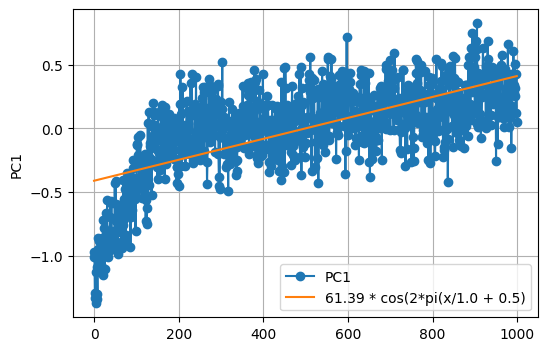

1
Params: A: 0.26847716574004915, T: 1.000982270444741, PHI: 1.4776959276901829


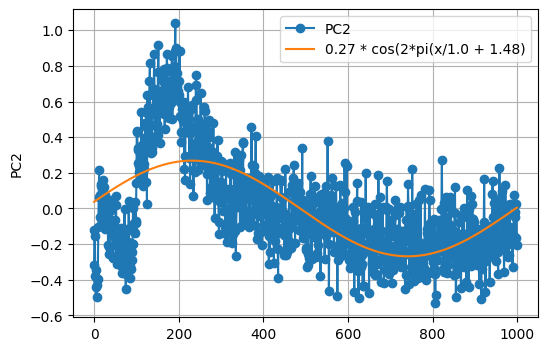

2
Params: A: 0.14600870147863682, T: 0.9991191220620008, PHI: 0.4422351292141118


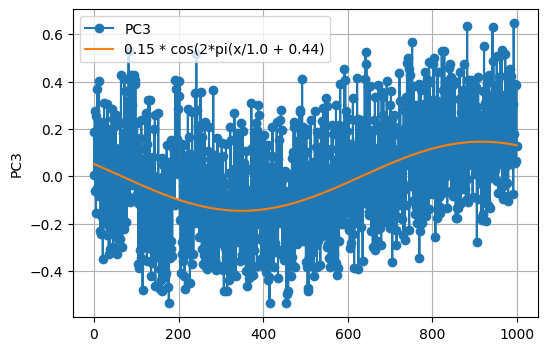

3
Params: A: 0.18040059255589538, T: 0.9989891264223933, PHI: -0.19339302045573686


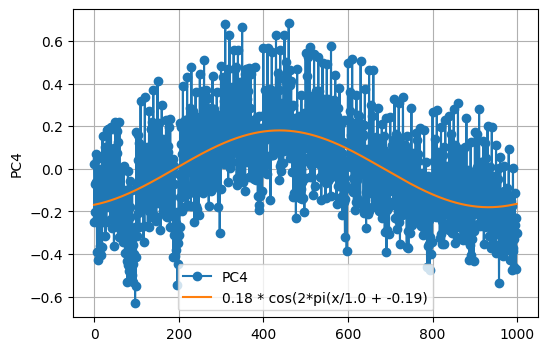

4
Params: A: -0.14855255010870208, T: 10.00036903966998, PHI: 1.231635617449975


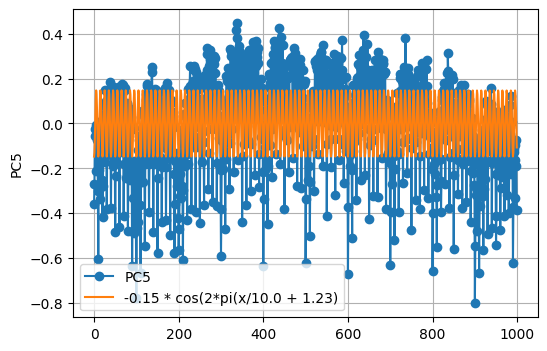

5
Params: A: -0.18260042378160204, T: 100.46708004041707, PHI: 1.0384768469470689


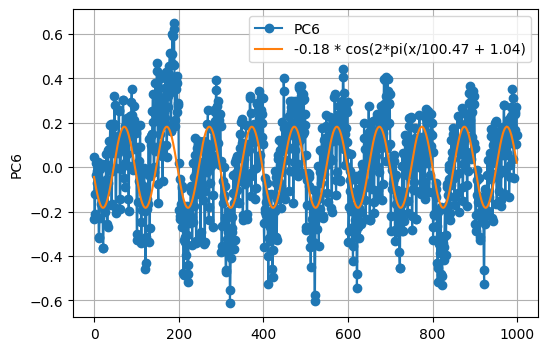

6
Params: A: -0.0469934623698921, T: 203.71002462301303, PHI: 1.1373548739062496


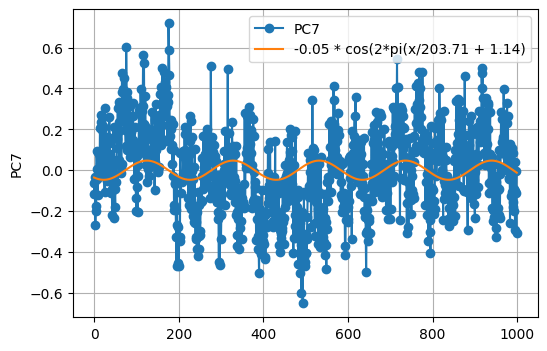

7
Params: A: -0.16633360167542957, T: 10.001301755656895, PHI: 0.8667135189491483


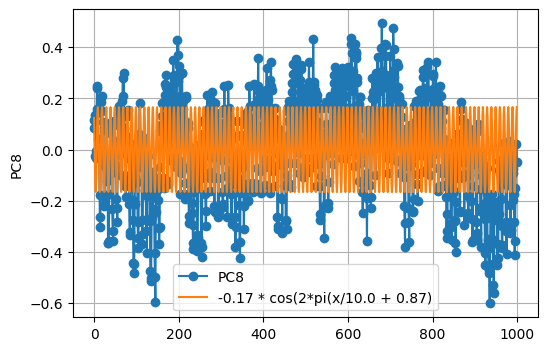

8
Params: A: -0.08127338287915484, T: 10.00453512982513, PHI: 1.0892267921981111


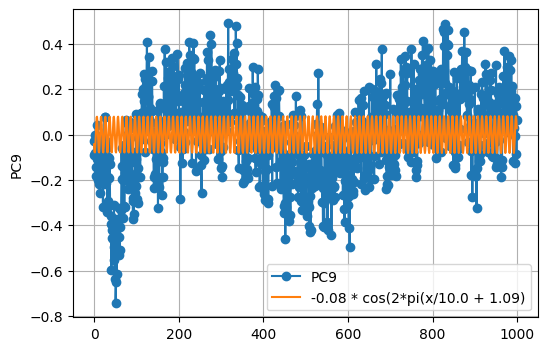

9
Params: A: 0.10887751006038282, T: 10.00112251690732, PHI: 0.7557500456518205


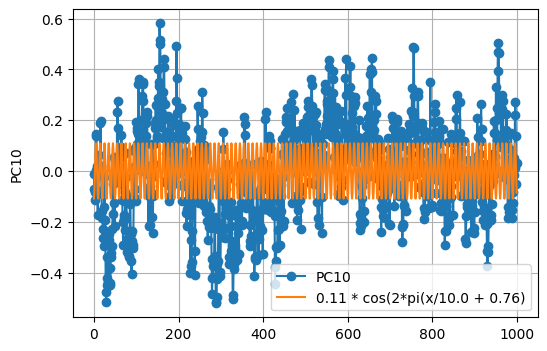

In [136]:
for cmpt, p0 in results:
        print(cmpt)
        PCA_COMPONENT = cmpt
        x_data = np.array(range(0, 1000))
        y_data = pca_result[:, PCA_COMPONENT]
        params, params_covariance = optimize.curve_fit(sin_func, x_data, y_data,
                                        p0=p0)
        print(f"Params: A: {params[0]}, T: {params[1]}, PHI: {params[2]}")
        plt.figure(figsize=(6, 4))
        plt.plot(x_data, y_data, label=f"PC{cmpt+1}", marker="o")
        plt.plot(x_data, sin_func(x_data, *params),
                label=f'{round(params[0], 2)} * cos(2*pi(x/{round(params[1], 2)} + {round(params[2], 2)})')
        #plt.plot(x_data, sin_func(x_data, params[0], params[1], params[2]%1),
        #        label=f'{round(params[0], 2)} * cos(2*pi(x/{round(params[1], 2)} + 0.{str(round(params[2], 2)).split(".")[1]})')
        
        plt.ylabel(f"PC{cmpt+1}")
        #plt.plot(x_data, sin_func(x_data, *p0),
        #         label='String function')

        plt.legend(loc='best')
        plt.grid()
        plt.show()

In [75]:
pca_result.shape

(100, 10)

In [ ]:
# Compute Fourier transform for each component and plot the frequencies, with a vertical line on the frequency identified by the sin fit
from scipy.fft import fft, ifft
import numpy as np

pca_cmpt = 1
x = pca_result[:, pca_cmpt]
y = fft(x)
y

array([-4.76837158e-07-0.j        ,  1.78810844e+01+9.233361j  ,
        2.82085419e+00-0.9396345j ,  2.14043951e+00-2.1098044j ,
        3.29306364e-01-1.861051j  , -1.81602344e-01-2.7989728j ,
       -4.00954187e-01-0.1221351j , -8.90334010e-01-1.1683115j ,
        2.96490818e-01+0.12197512j,  2.03385428e-01+1.0034151j ,
        6.16955340e-01+1.6662303j ,  6.01880670e-01+0.37707835j,
        5.67745328e-01+0.3442527j ,  2.65801966e-01-0.75464237j,
        8.12959075e-02-0.4141906j ,  3.81466061e-01-0.49779588j,
        3.74605358e-01-0.37355608j, -4.41302359e-01-0.37225252j,
       -9.90123987e-01-0.04885419j, -4.22688872e-01-0.9134343j ,
        3.10508132e-01+1.3768611j ,  7.79823363e-02+0.7479842j ,
        2.98894644e-02+0.06458485j,  1.00357294e-01+0.72314155j,
       -2.02892542e-01+0.6763804j ,  8.29932690e-01-0.05509126j,
       -2.93967962e-01-0.97068524j, -9.84294415e-02-0.48319626j,
        5.27962804e-01-0.2803315j , -1.03270614e+00-0.29897574j,
        3.24170351e-01+0.

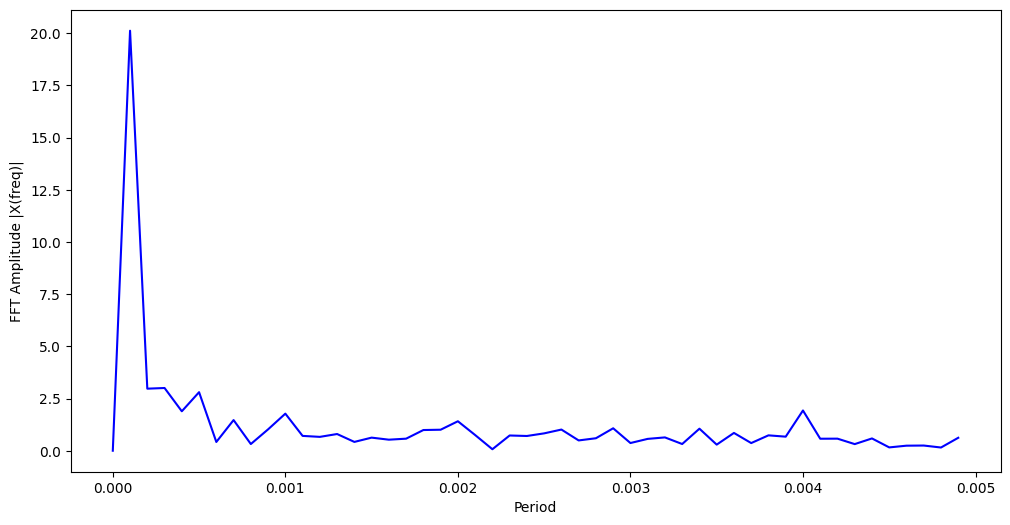

In [84]:
X = fft(x)
N = len(X)
n = np.arange(N)
# get the sampling rate
sr = 1 / (100)
T = N/sr
freq = n/T 

# Get the one-sided specturm
n_oneside = N//2
# get the one side frequency
f_oneside = freq[:n_oneside]

plt.figure(figsize = (12, 6))
plt.plot(f_oneside, np.abs(X[:n_oneside]), 'b')
plt.xlabel('Period')
plt.ylabel('FFT Amplitude |X(freq)|')
plt.show()

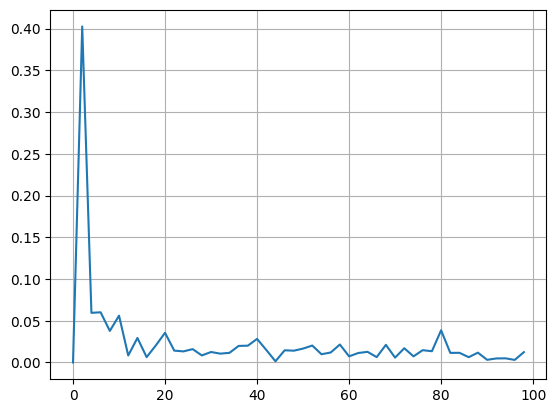

In [92]:
from scipy.fft import fft, fftfreq
import numpy as np
# Number of sample points
N = 100
# sample spacing
T = 1.0 / 200.0
x = np.linspace(0.0, N*T, N, endpoint=False)
pca_cmpt = 1
y = pca_result[:, pca_cmpt]
yf = fft(y)
xf = fftfreq(N, T)[:N//2]
import matplotlib.pyplot as plt
plt.plot(xf, 2.0/N * np.abs(yf[0:N//2]))
plt.grid()
plt.show()

### Computing relative change of phase to identifying circular coordinates (cos(x) sin(x)) 

### Fourier 

In [24]:
# Fir Fourier model
from symfit import parameters, variables, sin, cos, Fit
import numpy as np
import matplotlib.pyplot as plt

def fourier_series(x, f, n=0):
    """
    Returns a symbolic fourier series of order `n`.

    :param n: Order of the fourier series.
    :param x: Independent variable
    :param f: Frequency of the fourier series
    """
    # Make the parameter objects for all the terms
    a0, *cos_a = parameters(','.join(['a{}'.format(i) for i in range(0, n + 1)]))
    sin_b = parameters(','.join(['b{}'.format(i) for i in range(1, n + 1)]))
    # Construct the series
    series = a0 + sum(ai * cos(i * f * x) + bi * sin(i * f * x)
                     for i, (ai, bi) in enumerate(zip(cos_a, sin_b), start=1))
    return series

x, y = variables('x, y')
w, = parameters('w')
model_dict = {y: fourier_series(x, f=w, n=10)}
print(model_dict)

{y: a0 + a1*cos(w*x) + a10*cos(10*w*x) + a2*cos(2*w*x) + a3*cos(3*w*x) + a4*cos(4*w*x) + a5*cos(5*w*x) + a6*cos(6*w*x) + a7*cos(7*w*x) + a8*cos(8*w*x) + a9*cos(9*w*x) + b1*sin(w*x) + b10*sin(10*w*x) + b2*sin(2*w*x) + b3*sin(3*w*x) + b4*sin(4*w*x) + b5*sin(5*w*x) + b6*sin(6*w*x) + b7*sin(7*w*x) + b8*sin(8*w*x) + b9*sin(9*w*x)}


In [25]:
PCA_COMPONENT = 3
for component in range(PCA_COMPONENT):
    x_data = np.array(range(0, 100))
    y_data = pca_result[:, component]
    # Define a Fit object for this model and data
    model_dict = {y: fourier_series(x, f=w, n=10)}
    fit = Fit(model_dict, x=x_data, y=y_data)
    fit_result = fit.execute()
    print(fit_result)

    # Plot the result
    plt.plot(x_data, y_data, label=f'PCA component {component}', marker="o")
    plt.plot(x_data, fit.model(x=x_data, **fit_result.params).y, color='orange', ls='-', label="Fitted Fourier")
    plt.grid()
    plt.legend()
    plt.show()

/home/nicolobrunello/miniconda/envs/nlp/lib/python3.12/site-packages/symfit/core/fit.py:32: SyntaxWarning:

invalid escape sequence '\_'



AttributeError: module 'numpy' has no attribute 'product'